Columns: Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,603 (5.07 MB)

 Trainable params: 1,329,603 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.6963 - loss: 0.8872 - val_accuracy: 0.7730 - val_loss: 0.6722
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.7813 - loss: 0.6406 - val_accuracy: 0.7730 - val_loss: 0.6775
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7953 - loss: 0.6190 - val_accuracy: 0.7730 - val_loss: 0.6656
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7566 - loss: 0.6971 - val_accuracy: 0.7730 - val_loss: 0.6668
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7747 - loss: 0.6798 - val_accuracy: 0.7730 - val_loss: 0.6673
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.00      0.00      0.00       290
Offensive Language       0.77      1.00      0.87      3832
           Neither       0.00      0.00      0.00       835

          accuracy                           0.77      49

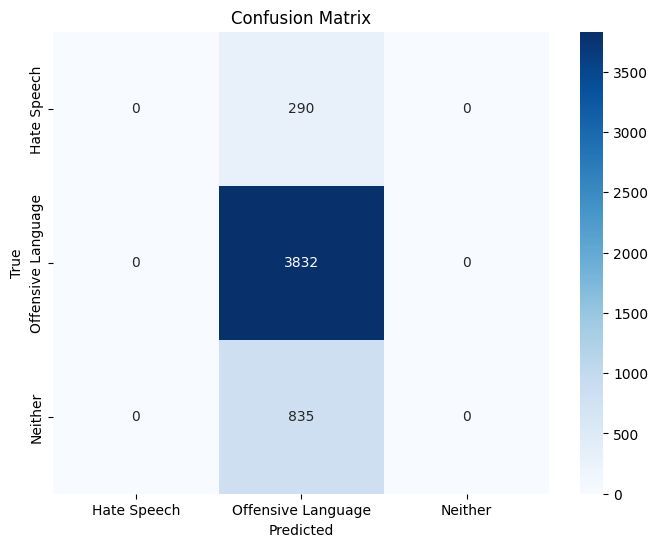

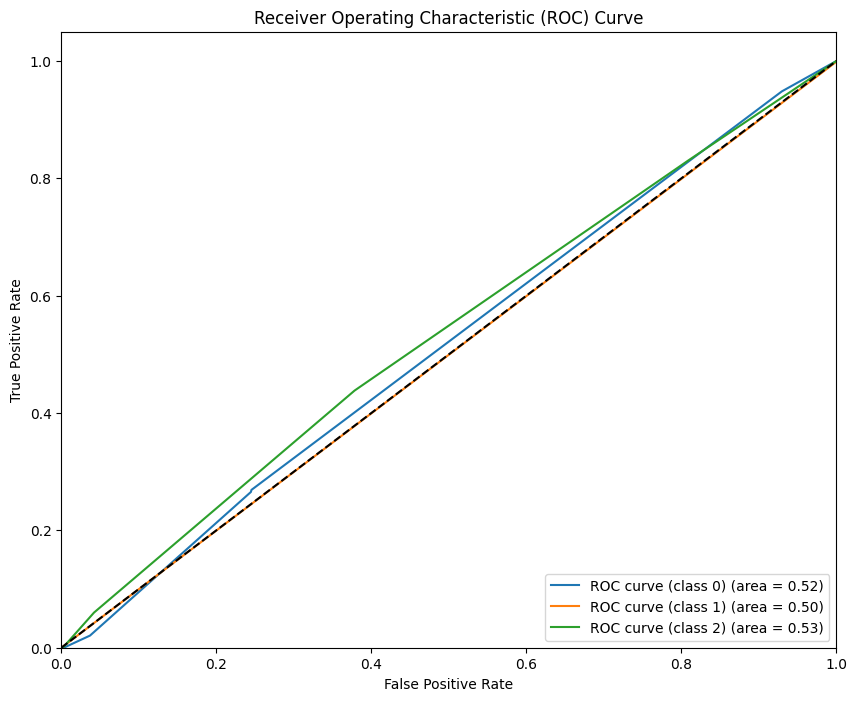

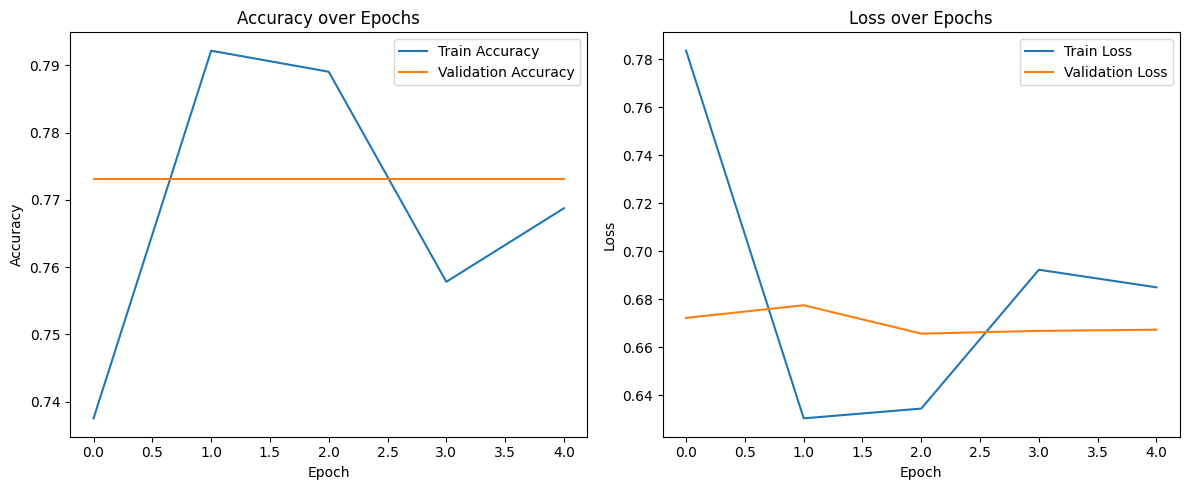

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv")
print("Columns:", df.columns)
print(df.head())

# Define text and label columns
TEXT_COLUMN = 'tweet'
LABEL_COLUMN = 'class'

# Preprocessing
X = df[TEXT_COLUMN].astype(str)
y = df[LABEL_COLUMN]

# One-hot encode labels
num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 100  # Adjust based on your text length analysis
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Define the model
embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation='softmax')
])

# Build the model to fix unbuilt warning
model.build(input_shape=(None, max_len))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
epochs = 5
batch_size = 32
steps_per_epoch = 20

# Calculate the number of samples to process per epoch
samples_per_epoch = steps_per_epoch * batch_size

# If your training data size is smaller than samples_per_epoch,
# you might want to adjust steps_per_epoch or increase your data.
if len(X_train_pad) < samples_per_epoch:
    print(f"Warning: Training data size ({len(X_train_pad)}) is less than the requested samples per epoch ({samples_per_epoch}). The epoch will complete after processing all available training data.")

history = model.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test_pad, y_test)
)

# Evaluation
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["Hate Speech", "Offensive Language", "Neither"], zero_division=0))

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Hate Speech", "Offensive Language", "Neither"],
            yticklabels=["Hate Speech", "Offensive Language", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (for multi-class, we'll plot one ROC per class)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
